2. Simulate the dynamics of the cat qubits at the circuit level

Tutorial 2: ATS with a flux pump can be used to engineer the 2-photon interaction
we would like to engineer a process that exchanges 2 photons of the memory with one photon in the buffer

|██████████| 100.0% ◆ elapsed 93.89ms ◆ remaining 0.00ms
100%|██████████| 120/120 [00:12<00:00,  9.72it/s]


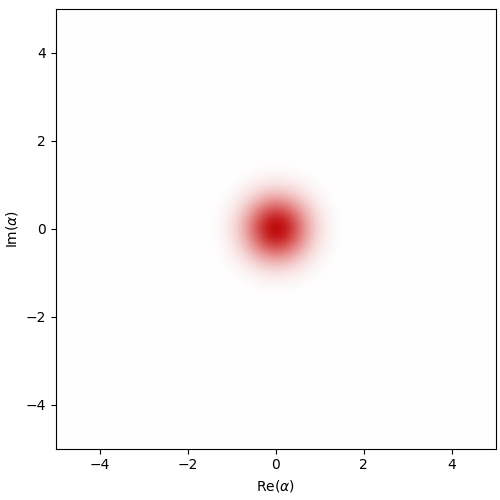

In [1]:
import dynamiqs as dq
import jax.numpy as jnp
from matplotlib import pyplot as plt
dq.set_device('cpu')
omega_a = 1.0 # eigenfrequency of the mode
epsilon_d = 2.0 # drive strength
omega_d = 1.0 # resonant drive
kappa_a = 1.2 # single photo loss rate

na = 20 # Hilbert space size (how many photos are present)
a = dq.destroy(na) # annihilation operator (lowers the no.of photon)
adag = a.dag() #creation operator
psi0 = dq.coherent(na, 0.0) # start in the vaccum
H_d = dq.modulated(lambda t: epsilon_d*jnp.exp(1j*omega_d*t), adag) + dq.hc
#how external drive interacts with the system
H_0 = omega_a * adag @ a
H = H_0 + H_d

tsave = jnp.linspace(0, 20, 400) # time grid (20 units, 400 time steps)
res = dq.mesolve(H, [jnp.sqrt(kappa_a)*a], psi0, tsave)
dq.plot.wigner_gif(res.states, fps = 24)



simulate the time - evolution of this system with the following parameters

|██████████| 100.0% ◆ elapsed 15.10s ◆ remaining 0.00ms  
ERROR:2025-02-02 04:32:34,032:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` 

KeyboardInterrupt: 

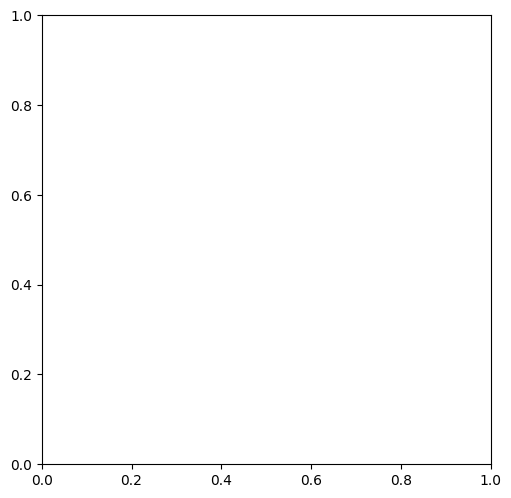

In [2]:
import dynamiqs as dq
import jax.numpy as jnp
from matplotlib import pyplot as plt
dq.set_device('cpu')

omega_a = 5.26e9
omega_b = 7.70e9
phi_a = 0.06
phi_b = 0.29
E_J = 42.76e9
delta_E_J = 0.47e9
omega_d = 7.623e9
omega_p = 2.891e9
epsilon_d = -3.815e6
epsilon_p = 0.122
T = 10e-6
tsave = jnp.linspace(0, T, 1000)
na = 20 #Hilbert space size for mode a
nb = 20 #Hilbert space size for mode b
a = dq.destroy(na) #annihilation operator for mode a
b = dq.destroy(nb) #annihilation operator for mode b
adag = a.dag() # creation operator for mode a
bdag = b.dag() # creation operator for mode b
psi0_a = dq.coherent(na, 0.0)
psi0_b = dq.coherent(nb, 0.0)
psi0 = psi0_a.elmul(psi0_b) # element - wise multiplication

H_0 = omega_a * adag @ a + omega_b * bdag @ b #Free hamiltonian
H_d = dq.modulated(lambda t: epsilon_d * jnp.exp(1j * omega_d * t), adag) + dq.hc # for mode a

H_p = dq.modulated(lambda t: epsilon_p * bdag @ b * jnp.exp(1j * omega_p * t), bdag) + dq.hc
H = H_0 + H_d


res = dq.mesolve(H, [jnp.sqrt(1.0) * a], psi0, tsave)
dq.plot.wigner_gif(res.states, fps=24)
plt.show()



|██████████| 100.0% ◆ elapsed 77.37ms ◆ remaining 0.00ms
100%|██████████| 120/120 [00:13<00:00,  9.06it/s]
|██████████| 100.0% ◆ elapsed 57.59ms ◆ remaining 0.00ms
100%|██████████| 120/120 [00:13<00:00,  9.06it/s]


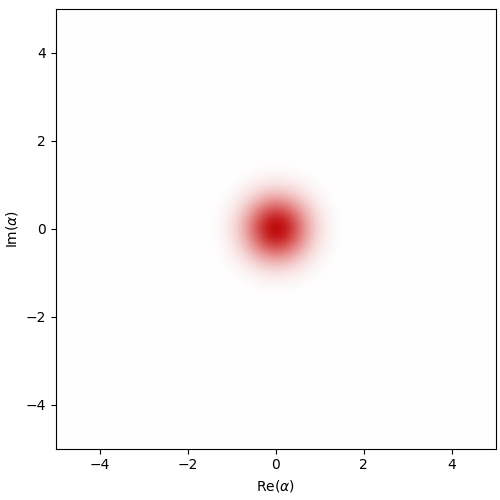

In [32]:
import dynamiqs as dq
import jax.numpy as jnp
omega_a = 1.0
epsilon_d = 2.0
omega_d = 1.0
kappa_a = 1.2
na = 20
a = dq.destroy(na)
adag = a.dag()
psi0 = dq.coherent(na, 0.0)
H_d = dq.modulated(lambda t: epsilon_d * jnp.exp(1j * omega_d * t), adag) + dq.hc
H_0 = omega_a * adag @ a
H = H_0 + H_d
tsave = jnp.linspace(0, 20, 400)
res = dq.mesolve(H, [jnp.sqrt(kappa_a) * a], psi0, tsave)
dq.plot.wigner_gif(res.states, fps = 24)
def alpha(t):
    num = -1j * epsilon_d * jnp.exp(1j * omega_d * t)
    denom = kappa_a/2 + 1j * (omega_a - omega_d) 
    return num/denom
def dalpha(t):
    return 1j * omega_d * alpha(t)
I = dq.eye(na)
H_d = dq.timecallable(lambda t: epsilon_d*jnp.exp(1j*omega_d*t) * (adag + jnp.conj(alpha(t))*I)
                      + jnp.conj(epsilon_d)*jnp.exp(-1j*omega_d*t) * (a + alpha(t)*I))
H_0 = omega_a * dq.timecallable(lambda t: (adag + jnp.conj(alpha(t)) * I) @ (a + alpha(t) * I))
H_nu = dq.timecallable(lambda t: (1j * jnp.conj(dalpha(t)) * a - 1j * dalpha(t) * adag))
lop = dq.timecallable(lambda t: jnp.sqrt(kappa_a) * (a + alpha(t) * I))
psi0 = dq.todm(dq.coherent(na, 0.0))
tsave = jnp.linspace(0, 50, 400)
res_displaced = dq.mesolve(H, [lop], psi0, tsave)
dq.plot.wigner_gif(res_displaced.states, fps = 24)



Simulate the time - evolution of this system 
1. define parameters
2. construct hamiltonian
3. include dissipation via the lindblad master equation
4. solve the dynamics starting from the vacuum state
5. plot the wigner function for mode a

QArray: shape=(16, 16), dims=(4, 4), dtype=complex64, layout=dia, ndiags=1
[[0.8737617+0.j       ⋅             ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅      ]
 [      ⋅       0.8737617+0.j       ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅      ]
 [      ⋅             ⋅       0.8737617+0.j       ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅      ]
 [      ⋅             ⋅             ⋅       0.8737617+0.j       ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅             ⋅             ⋅             ⋅             ⋅      
        ⋅ 

|██████████| 100.0% ◆ elapsed 30.50s ◆ remaining 0.00ms  
ERROR:2025-02-02 06:27:01,649:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` 

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sCpuCallback error: Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2960, in _wrapped_callback
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 306, in _callback
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 98, in pure_callback_impl
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
  File "/opt/conda/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


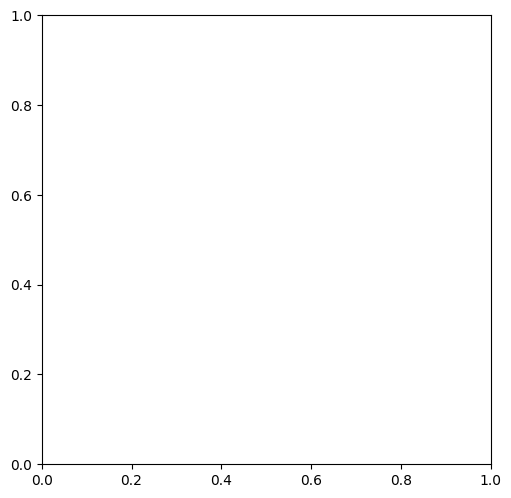

In [1]:
import dynamiqs as dq
import numpy as np
import jax.numpy as jnp
from scipy.linalg import expm, cosm, sinm

# Parameters

omega_a0 = 5.26e9 * 2 * np.pi
omega_b0 = 7.70e9 * 2 * np.pi

phi_a = 0.06
phi_b = 0.29
# E_J = 4.276e10
# Delta_E_J = 4.7e8
# omega_d = 7.623e9
# omega_p = 2.891e9
# epsilon_d = -3815000
# epsilon_p = 0.122  # rad
# kappa_a = 9300
# kappa_b = 2.6e6

E_J = 12.03e9 
Delta_E_J = 0.47e9
omega_d = 7.623e9 * 2 * np.pi
omega_p = 2.891e9 * 2 * np.pi
epsilon_d = -3.815e6 * 2 * np.pi
epsilon_p = 0.122 
kappa_a = 9.3e3 * 2 * np.pi
kappa_b = 2.6e6 * 2 * np.pi

na, nb = 4, 4
a = dq.tensor(dq.destroy(na), dq.eye(nb))
adag = dq.dag(a)
b = dq.tensor(dq.eye(na), dq.destroy(nb))
bdag = dq.dag(b)

# Define time-dependent functions
def epsilon_t(t):
    return epsilon_p * jnp.cos(omega_p * t)

def sin_op(op):
    out = dq.zeros_like(op)
    term = op
    for j in range(20):
        out = out + term
        term = -(term @ op) * (1 / ((2 * j + 2) * (2 * j + 3)))
    return out

def cos_op(op):
    out = dq.zeros_like(op)
    term = dq.eye_like(op)
    for j in range(20):
        out = out + term
        term = -(term @ op) * (1 / ((2 * j + 1) * (2 * j + 2)))
    return out

print(sin_op(jnp.pi/3 * dq.eye(na, nb)))
print(jnp.sin(jnp.pi/3))

print(cos_op(jnp.pi/3 * dq.eye(na, nb)))
print(jnp.cos(jnp.pi/3))

phi = phi_a * (a + adag) + phi_b * (b + bdag)
cos_phi = dq.asqarray(cosm(phi), dims=(na, nb))
sin_phi = dq.asqarray(sinm(phi), dims=(na, nb))


H_0 = omega_a0 * adag @ a + omega_b0 * bdag @ b  # Free Hamiltonian


# Time-dependent components
def H_ATS_t(t):
    return -2 * E_J * jnp.sin(epsilon_t(t)) * sin_phi + 2 * Delta_E_J * jnp.cos(epsilon_t(t)) * cos_phi
    #return -2 * E_J * jnp.sin(epsilon_d * t) * jnp.sin(phi_a) + 2 * Delta_E_J * jnp.cos(epsilon_d * t) * jnp.cos(phi_b)


H_ATS = dq.timecallable(H_ATS_t)

def H_d_t(t):
    return 2 * epsilon_d * jnp.cos(omega_d * t) * (b + bdag)


H_ATS = dq.timecallable(H_ATS_t)
H_d = dq.timecallable(H_d_t)  # Ensure dimensions match


# Total Hamiltonian
H = H_d + H_ATS + H_0

print(type(H))
print(type(H_0))
print(type(H_ATS))
print(type(H_d))



# Lindblad operators
L_a = jnp.sqrt(kappa_a) * a
L_b = jnp.sqrt(kappa_b) * b
loss_ops = [L_a, L_b]
print(L_a.dims)

# Initial state
psi0 = dq.fock((na, nb), (0,0))

# Time evolution
T = 500e-9 # s
tsave = np.linspace(0, T, 50)
res = dq.mesolve(H, loss_ops, psi0, tsave)


# Plot Wigner function
wigner_states = dq.ptrace(res.states, 0, (na, nb))
dq.plot.wigner_gif(wigner_states, fps=24)


<class 'dynamiqs.time_qarray.SummedTimeQArray'>
<class 'dynamiqs.qarrays.sparsedia_qarray.SparseDIAQArray'>
<class 'dynamiqs.time_qarray.CallableTimeQArray'>
<class 'dynamiqs.time_qarray.CallableTimeQArray'>
(4, 4)


|██████████| 100.0% ◆ elapsed 18.71s ◆ remaining 0.00ms  
ERROR:2025-02-02 07:00:54,656:jax._src.callback:97: jax.pure_callback failed
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` 

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sError dispatching computation: %sCpuCallback error: Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2960, in _wrapped_callback
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 306, in _callback
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 98, in pure_callback_impl
  File "/opt/conda/lib/python3.11/site-packages/jax/_src/callback.py", line 72, in __call__
  File "/opt/conda/lib/python3.11/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


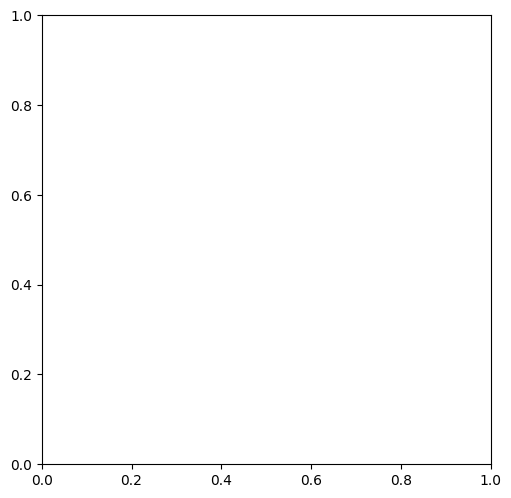

In [3]:
import dynamiqs as dq
import numpy as np
import jax.numpy as jnp
from scipy.linalg import expm, cosm, sinm

# Parameters

omega_a0 = 5.26e9 * 2 * np.pi
omega_b0 = 7.70e9 * 2 * np.pi

phi_a = 0.06
phi_b = 0.29
# E_J = 4.276e10
# Delta_E_J = 4.7e8
# omega_d = 7.623e9
# omega_p = 2.891e9
# epsilon_d = -3815000
# epsilon_p = 0.122  # rad
# kappa_a = 9300
# kappa_b = 2.6e6

E_J = 12.03e9 
Delta_E_J = 0.47e9
omega_d = 7.623e9 * 2 * np.pi
omega_p = 2.891e9 * 2 * np.pi
epsilon_d = -3.815e6 * 2 * np.pi
epsilon_p = 0.122 
kappa_a = 9.3e3 * 2 * np.pi
kappa_b = 2.6e6 * 2 * np.pi

na, nb = 4, 4
a = dq.tensor(dq.destroy(na), dq.eye(nb))
adag = dq.dag(a)
b = dq.tensor(dq.eye(na), dq.destroy(nb))
bdag = dq.dag(b)

# Define time-dependent functions
def epsilon_t(t):
    return epsilon_p * jnp.cos(omega_p * t)

# def sin_op(op):
#     out = dq.zeros_like(op)
#     term = op
#     for j in range(20):
#         out = out + term
#         term = -(term @ op) * (1 / ((2 * j + 2) * (2 * j + 3)))
#     return out

# def cos_op(op):
#     out = dq.zeros_like(op)
#     term = dq.eye_like(op)
#     for j in range(20):
#         out = out + term
#         term = -(term @ op) * (1 / ((2 * j + 1) * (2 * j + 2)))
#     return out

# print(sin_op(jnp.pi/3 * dq.eye(na, nb)))
# print(jnp.sin(jnp.pi/3))

# print(cos_op(jnp.pi/3 * dq.eye(na, nb)))
# print(jnp.cos(jnp.pi/3))

phi = phi_a * (a + adag) + phi_b * (b + bdag)
cos_phi = dq.asqarray(cosm(phi), dims=(na, nb))
sin_phi = dq.asqarray(sinm(phi), dims=(na, nb))


H_0 = omega_a0 * adag @ a + omega_b0 * bdag @ b  # Free Hamiltonian


# Time-dependent components
def H_ATS_t(t):
    #return -2 * E_J * jnp.sin(epsilon_t(t)) * sin_phi + 2 * Delta_E_J * jnp.cos(epsilon_t(t)) * cos_phi
    return -2 * E_J * jnp.sin(epsilon_t(t)) * sin_phi + 2 * Delta_E_J * jnp.cos(epsilon_t(t)) * cos_phi


H_ATS = dq.timecallable(H_ATS_t)

def H_d_t(t):
    return 2 * epsilon_d * jnp.cos(omega_d * t) * (b + bdag)


H_ATS = dq.timecallable(H_ATS_t)
H_d = dq.timecallable(H_d_t)  # Ensure dimensions match


# Total Hamiltonian
H = H_d + H_ATS + H_0

print(type(H))
print(type(H_0))
print(type(H_ATS))
print(type(H_d))



# Lindblad operators
L_a = jnp.sqrt(kappa_a) * a
L_b = jnp.sqrt(kappa_b) * b
loss_ops = [L_a, L_b]
print(L_a.dims)

# Initial state
psi0 = dq.fock((na, nb), (0,0))

# Time evolution
T = 1e-6 # s
tsave = np.linspace(0, T, 400)
res = dq.mesolve(H, loss_ops, psi0, tsave)


# Plot Wigner function
dq.plot.wigner_gif(dq.ptrace(res.states, 0, (na, nb)))

In [7]:
import dynamiqs as dq
import numpy as np
import jax.numpy as jnp
from scipy.linalg import expm, cosm, sinm

GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

omega_a0 = 5.26 * GHz # bare resonant frequency of mode a
omega_b0 = 7.7 * GHz # bare resonant frequency of mode b
phi_a = 0.06 # zero-point fluctuation phase of mode a
phi_b = 0.29 # zero-point fluctuation phase of mode a
E_J = 12.03 * GHz # Josephson energy
Delta_E_J = 0.47 * GHz

omega_d = 7.623 * GHz
omega_p = 2.891 * GHz
epsilon_d = -3.815 * MHz
epsilon_p = 0.122 
kappa_a = 9.3 * kHz # relaxation rate of mode a
kappa_b = 2.6 * MHz # relaxation rate of mode b

na, nb = 20, 5
# a = dq.tensor(dq.destroy(na), dq.eye(nb))
adag = dq.dag(a)
# b = dq.tensor(dq.eye(na), dq.destroy(nb))
bdag = dq.dag(b)
a,b = dq.destroy(na, nb)

# Define time-dependent functions
# def epsilon_t(t):
#     return epsilon_p * jnp.cos(omega_p * t)





# H_0 = omega_a0 * adag @ a + omega_b0 * bdag @ b  # Free Hamiltonian

phi = phi_a * (a + adag) + phi_b * (b + bdag)

# H_ATS = dq.modulated(lambda t: -2 * E_J * (jnp.sin(epsilon_p*jnp.cos(omega_p*t))), dq.sinm(phi)) + dq.modulated(lambda t: 2 * Delta_E_J * jnp.cos(epsilon_p * jnp.cos(omega_d * t)), dq.cosm(phi))

# H_d = dq.modulated(lambda t: 2 * epsilon_d * jnp.cos(omega_d * t), (b + bdag))
H_0 = omega_a0 * adag @ a + omega_b0 * bdag @ b 

H_ATS = dq.modulated(lambda t: -2* E_J*(jnp.sin(epsilon_p * jnp.cos(omega_p * t))), dq.sinm(phi)) + dq.modulated(lambda t : 2 * Delta_E_J * jnp.cos(epsilon_p * jnp.cos(omega_d * t)), dq.cosm(phi))

H_d = dq.modulated(lambda t: 2 * epsilon_d * jnp.cos(omega_d * t), (b + bdag))

H = H_0 + H_ATS + H_d

# Total Hamiltonian







# Lindblad operators
L_a = jnp.sqrt(kappa_a) * dq.tensor(a, dq.eye(nb))
L_b = jnp.sqrt(kappa_b) * dq.tensor(dq.eye(na), b)
loss_ops = [L_a, L_b]

# Initial state
psi0 = dq.fock((na, nb), (0,0)) #coherent

# Time evolution
T = 3e-6
tsave = np.linspace(0, T, 50)
res = dq.mesolve(H, loss_ops, psi0, tsave)


# Plot Wigner function
trace_a = dq.ptrace(res.states, 0, res.states.dims)
dq.plot.wigner_gif(trace_a, fps=120)

/opt/conda/lib/python3.11/site-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)


ValueError: Terms are not compatible with solver!

/opt/conda/lib/python3.11/site-packages/equinox/_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
|██████████| 100.0% ◆ elapsed 75.43ms ◆ remaining 0.00ms
100%|██████████| 50/50 [00:03<00:00, 13.04it/s]


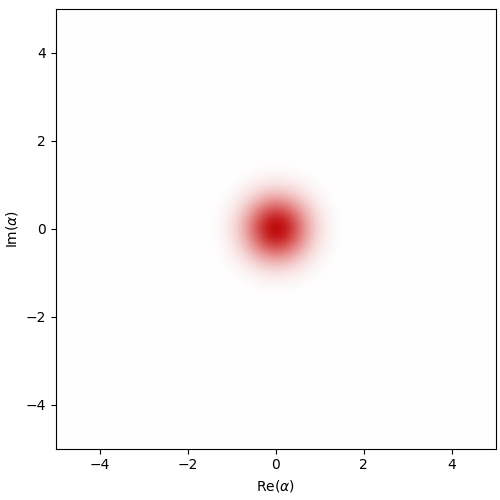

In [24]:
import dynamiqs as dq
import scipy as sp
import jax
import jax.numpy as jnp # the JAX version of numpy
from matplotlib import pyplot as plt
import scipy.constants

jax.devices()
dq.set_device('cpu')

dq.set_precision('simple')

na, nb = 20, 5
a = dq.tensor(dq.destroy(na), dq.eye(nb))
adag = dq.dag(a)
b = dq.tensor(dq.eye(na), dq.destroy(nb))
bdag = dq.dag(b)

GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

omega_a0 = 2*jnp.pi*5.26*GHz
omega_b0 = 2*jnp.pi*7.70*GHz
phi_a = 0.06
phi_b = 0.29
h = 6e-34
kappa_b = 2.6*MHz
E_J = 12.03* h*GHz
Delta_E_J = 0.47 * h *GHz
T = 10e-9
t_save = jnp.linspace(0, T, 50)  # save times
omega_d = 2*jnp.pi*7.623*GHz
omega_p = 2*jnp.pi*2.891*GHz
epsilon_d = -2*jnp.pi*3.815*MHz #This is MHz but rest is GHz 
epsilon_p = 0.122

# omega_a0 = 2*jnp.pi*5.26
# omega_b0 = 2*jnp.pi*7.70
# phi_a = 0.06
# phi_b = 0.29
# h = 6e-34
# kappa_b = 2.6
# E_J = 12.03* h
# Delta_E_J = 0.47 * h 
# T = 10e-9
# t_save = jnp.linspace(0, T, 50)  # save times
# omega_d = 2*jnp.pi*7.623
# omega_p = 2*jnp.pi*2.891
# epsilon_d = -2*jnp.pi*3.815*MHz #This is MHz but rest is GHz 
# epsilon_p = 0.122

phi_hat = phi_a * (a + adag) + phi_b * (b + bdag)

H_0 = omega_a0 * adag @ a + omega_b0 * bdag @ b 

H_ATS = dq.modulated(lambda t: -2* E_J*(jnp.sin(epsilon_p * jnp.cos(omega_d * t))), dq.sinm(phi_hat)) + dq.modulated(lambda t : 2 * Delta_E_J * jnp.cos(epsilon_p * jnp.cos(omega_d * t)), dq.cosm(phi_hat))

H_d = dq.modulated(lambda t: 2 * epsilon_d * jnp.cos(omega_d * t), (b + bdag))

H = H_0 + H_ATS + H_d

# L_a = jnp.sqrt(kappa_a) * dq.tensor(a, dq.eye(nb))
# L_b = jnp.sqrt(kappa_b) * dq.tensor(dq.eye(na), b)
# loss_ops = [L_a, L_b]

psi0 = dq.fock((na,nb), (0,0))  # coherent state

res = dq.mesolve(H, [jnp.sqrt(kappa_a)*a], psi0, t_save)

trace_a = dq.ptrace(res.states, 0,res.states.dims) # trace of a

dq.plot.wigner_gif(trace_a, fps=120)